# Finetuning data: compare to pretraining and basic preparation

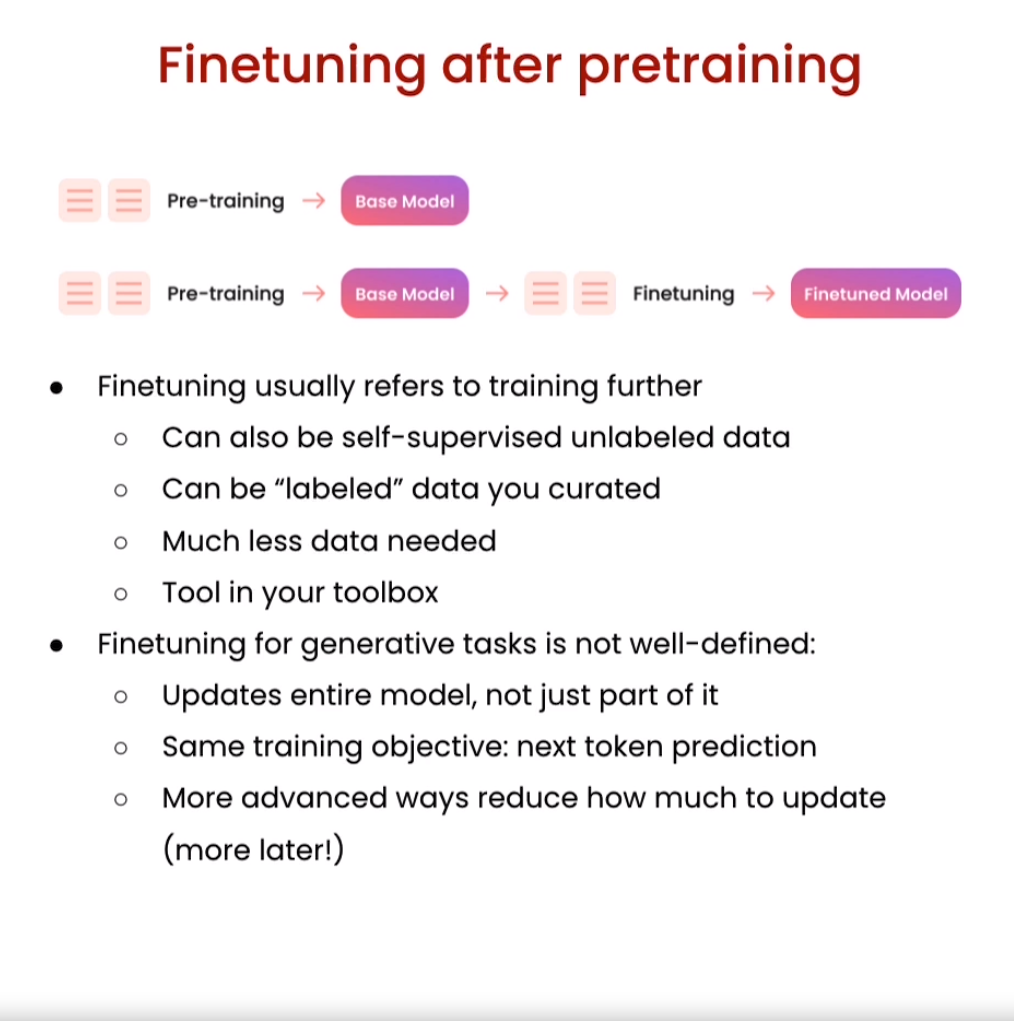

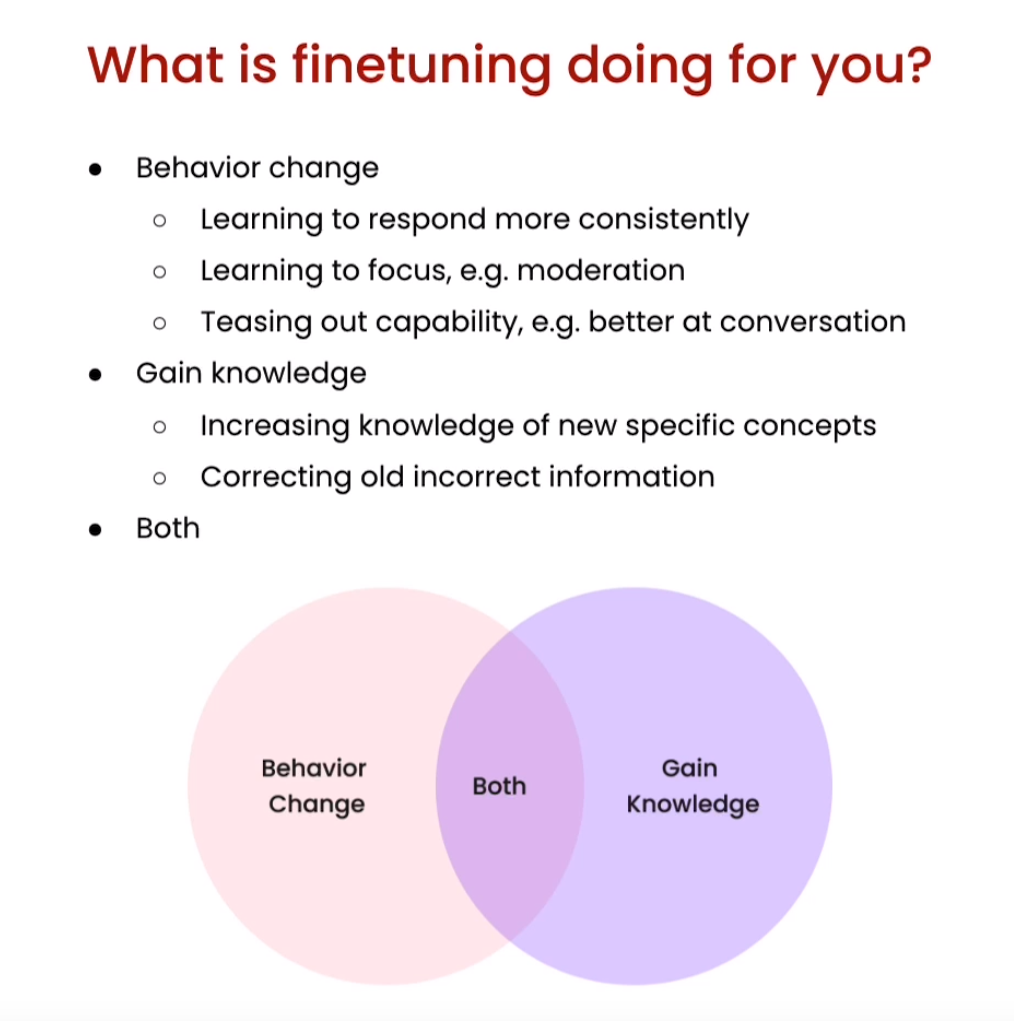

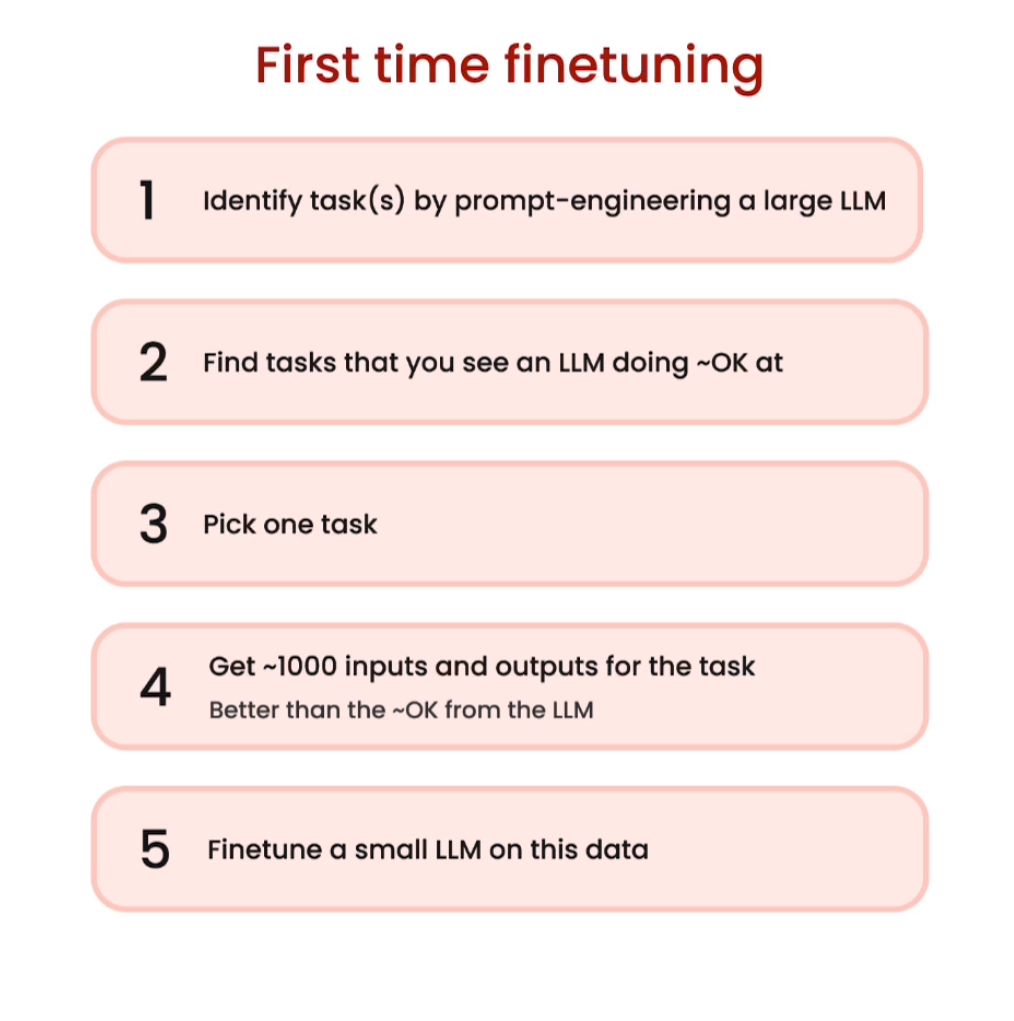

In [ ]:
import jsonlines
import itertools
import pandas as pd
from pprint import pprint

import datasets
from datasets import load_dataset

### Look at pretraining data set

**Sorry**, "The Pile" dataset is currently relocating to a new home and so we can't show you the same example that is in the video. Here is another dataset, the ["Common Crawl"](https://huggingface.co/datasets/c4) dataset.

In [ ]:
#pretrained_dataset = load_dataset("EleutherAI/pile", split="train", streaming=True)

pretrained_dataset = load_dataset("c4", "en", split="train", streaming=True)


/home/precision/miniconda3/envs/ds-env/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
n = 5
print("Pretrained dataset:")
top_n = itertools.islice(pretrained_dataset, n)
for i in top_n:
  print(i)

Pretrained dataset:
{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}
{'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb inter

### Contrast with company finetuning dataset you will be using

In [ ]:
# filename = "lamini_docs.jsonl"
# instruction_dataset_df = pd.read_json(filename, lines=True)
# instruction_dataset_df

In [ ]:
import pickle

with open('instruction_dataset_df.pkl', 'rb') as f:
    instruction_dataset_df = pickle.load(f)

In [ ]:
instruction_dataset_df.to_json()

'{"question":{"0":"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer\'s guide)?","1":"What is the recommended way to set up and configure the code repository?","2":"How can I find the specific documentation I need for a particular feature or function?","3":"Does the documentation include explanations of the code\'s purpose and how it fits into a larger system?","4":"Does the documentation provide information about any external dependencies or libraries used by the code?","5":"How frequently is the documentation updated to reflect changes in the code?","6":"Is there a community or support channel mentioned in the documentation where I can ask questions or seek help?","7":"Are there any API references or documentation available for the codebase?","8":"Is there a troubleshooting guide or a list of common issues and their solutions?","9":"Are there any examples or sample code provided in the documentation?","10":"W

### Various ways of formatting your data

In [ ]:
examples = instruction_dataset_df.to_dict()
text = examples["question"][0] + examples["answer"][0]
text

"What are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?Lamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [ ]:
if "question" in examples and "answer" in examples:
  text = examples["question"][0] + examples["answer"][0]
elif "instruction" in examples and "response" in examples:
  text = examples["instruction"][0] + examples["response"][0]
elif "input" in examples and "output" in examples:
  text = examples["input"][0] + examples["output"][0]
else:
  text = examples["text"][0]

In [ ]:
prompt_template_qa = """### Question:
{question}

### Answer:
{answer}"""

In [ ]:
question = examples["question"][0]
answer = examples["answer"][0]

text_with_prompt_template = prompt_template_qa.format(question=question, answer=answer)
text_with_prompt_template

"### Question:\nWhat are the different types of documents available in the repository (e.g., installation guide, API documentation, developer's guide)?\n\n### Answer:\nLamini has documentation on Getting Started, Authentication, Question Answer Model, Python Library, Batching, Error Handling, Advanced topics, and class documentation on LLM Engine available at https://lamini-ai.github.io/."

In [ ]:
prompt_template_q = """### Question:
{question}

### Answer:"""

In [ ]:
num_examples = len(examples["question"])
finetuning_dataset_text_only = []
finetuning_dataset_question_answer = []
for i in range(num_examples):
  question = examples["question"][i]
  answer = examples["answer"][i]

  text_with_prompt_template_qa = prompt_template_qa.format(question=question, answer=answer)
  finetuning_dataset_text_only.append({"text": text_with_prompt_template_qa})

  text_with_prompt_template_q = prompt_template_q.format(question=question)
  finetuning_dataset_question_answer.append({"question": text_with_prompt_template_q, "answer": answer})

In [ ]:
pprint(finetuning_dataset_text_only[0])

{'text': '### Question:\n'
         'What are the different types of documents available in the '
         "repository (e.g., installation guide, API documentation, developer's "
         'guide)?\n'
         '\n'
         '### Answer:\n'
         'Lamini has documentation on Getting Started, Authentication, '
         'Question Answer Model, Python Library, Batching, Error Handling, '
         'Advanced topics, and class documentation on LLM Engine available at '
         'https://lamini-ai.github.io/.'}


In [ ]:
pprint(finetuning_dataset_question_answer[0])

{'answer': 'Lamini has documentation on Getting Started, Authentication, '
           'Question Answer Model, Python Library, Batching, Error Handling, '
           'Advanced topics, and class documentation on LLM Engine available '
           'at https://lamini-ai.github.io/.',
 'question': '### Question:\n'
             'What are the different types of documents available in the '
             'repository (e.g., installation guide, API documentation, '
             "developer's guide)?\n"
             '\n'
             '### Answer:'}


### Common ways of storing your data

In [ ]:
with jsonlines.open(f'lamini_docs_processed.jsonl', 'w') as writer:
    writer.write_all(finetuning_dataset_question_answer)

In [ ]:
finetuning_dataset_name = "lamini/lamini_docs"
finetuning_dataset = load_dataset(finetuning_dataset_name)
print(finetuning_dataset)

Generating train split:   0%|          | 0/1260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/140 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1260
    })
    test: Dataset({
        features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 140
    })
})


In [ ]:
import pickle
import base64
from IPython.display import HTML

def download_pickle(var, filename='downloaded_data.pkl'):

    pickled_var = pickle.dumps(var)

    b64_encoded_data = base64.b64encode(pickled_var).decode()

    download_html = f'<a href="data:application/octet-stream;base64,{b64_encoded_data}" download="{filename}">Download Pickled File</a>'
    display(HTML(download_html))


download_pickle(finetuning_dataset, 'finetuning_dataset.pkl')
